<a href="https://colab.research.google.com/github/ChaitaliV/generative-explanation/blob/main/unsupervised_pretraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers sentencepiece nltk evaluate rouge bleu rouge-score;
!git clone https://github.com/ChaitaliV/generative-explanation;

fatal: destination path 'generative-explanation' already exists and is not an empty directory.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from transformers import T5Tokenizer, T5Model, T5ForConditionalGeneration, T5TokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange
import pandas as pd
import torch
import nltk
import evaluate
from nltk.translate.bleu_score import sentence_bleu
import numpy as np
import matplotlib.pyplot as plt
from rouge import Rouge
from nltk.translate.bleu_score import sentence_bleu
nltk.download('punkt');

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Evaluate the model performace before and after pre-training

* take few sentences and tokenize them, mask one word from each sentence, and use model to predict the masked word.
* use model logits to get candidates for the masked word.
* calculate the rogue score between original and generated sentences.

In [4]:
depression_symptoms = [
    "Persistent sadness and a sense of hopelessness are common symptoms of depression.",
    "Changes in sleep patterns, such as insomnia or oversleeping, may indicate depressive symptoms.",
    "Fatigue and a lack of energy are often reported by individuals experiencing depression.",
    "Difficulty concentrating or making decisions is a cognitive symptom associated with depression.",
    "Feelings of worthlessness or excessive guilt can be indicative of depressive thoughts.",
    "Loss of interest or pleasure in activities once enjoyed is a hallmark symptom of depression.",
    "Appetite changes, leading to weight loss or gain, can be part of depressive symptoms.",
    "Irritability and restlessness are emotional symptoms that may accompany depression.",
    "Physical symptoms of depression may include headaches and unexplained body aches.",
    "Thoughts of death or suicide are severe symptoms requiring immediate attention.",
    "Social withdrawal and isolation are behavioral signs often seen in depression.",
    "Decreased libido and sexual dysfunction can be associated with depressive disorders.",
    "Psychomotor agitation or retardation may affect an individual's physical movements.",
    "Recurrent thoughts of death or suicide should be taken seriously and addressed promptly.",
    "Depressive symptoms in children may manifest as irritability and academic decline.",
    "Seasonal changes can contribute to Seasonal Affective Disorder (SAD), a subtype of depression.",
    "Anxiety often coexists with depression, and symptoms may overlap.",
    "Physical complaints, such as digestive issues, may be linked to underlying depression.",
    "Persistent feelings of emptiness and a lack of purpose are emotional symptoms of depression.",
    "Postpartum depression affects some women after giving birth and requires prompt diagnosis and treatment to support maternal well-being."
]

In [5]:
masks = ['sadness', 'oversleeping','lack', 'cognitive','excessive', 'pleasure',
         'Appetite','restlessness', 'headaches', 'suicide', 'behavioral', 'dysfunction',
         'physical', 'seriously', 'children', 'Disorder', 'coexists', 'depression',
         'symptoms', 'Postpartum'
         ]

In [6]:
depression_symptoms_masked = [
    "Persistent <extra_id_0> and a sense of hopelessness are common symptoms of depression.",
    "Changes in sleep patterns, such as insomnia or <extra_id_0>, may indicate depressive symptoms.",
    "Fatigue and a <extra_id_0> of energy are often reported by individuals experiencing depression.",
    "Difficulty concentrating or making decisions is a <extra_id_0> symptom associated with depression.",
    "Feelings of worthlessness or <extra_id_0> guilt can be indicative of depressive thoughts.",
    "Loss of interest or <extra_id_0> in activities once enjoyed is a hallmark symptom of depression.",
    "<extra_id_0> changes, leading to weight loss or gain, can be part of depressive symptoms.",
    "Irritability and <extra_id_0> are emotional symptoms that may accompany depression.",
    "Physical symptoms of depression may include <extra_id_0> and unexplained body aches.",
    "Thoughts of death or <extra_id_0> are severe symptoms requiring immediate attention.",
    "Social withdrawal and isolation are <extra_id_0> signs often seen in depression.",
    "Decreased libido and sexual <extra_id_0> can be associated with depressive disorders.",
    "Psychomotor agitation or retardation may affect an individual's <extra_id_0> movements.",
    "Recurrent thoughts of death or suicide should be taken <extra_id_0> and addressed promptly.",
    "Depressive symptoms in <extra_id_0> may manifest as irritability and academic decline.",
    "Seasonal changes can contribute to Seasonal Affective <extra_id_0>(SAD), a subtype of depression.",
    "Anxiety often <extra_id_0> with depression, and symptoms may overlap.",
    "Physical complaints, such as digestive issues, may be linked to underlying <extra_id_0>.",
    "Persistent feelings of emptiness and a lack of purpose are emotional <extra_id_0> of depression.",
    "<extra_id_0> depression affects some women after giving birth and requires prompt diagnosis and treatment to support maternal well-being."
]

In [7]:
class EvalModelTraining():

  def __init__(self, model, masked_test_data, actual_words):
    self.model = model
    self.tokenizer = T5Tokenizer.from_pretrained("t5-base")
    self.masked_test_data = masked_test_data
    self.actual_words = actual_words
    self.rouge = evaluate.load('rouge')
    self.candidate_list = []

  def eval_model(self):
    for i in range(0, len(self.masked_test_data)):
      input_ids = self.tokenizer(self.masked_test_data[i], max_length= 512, padding="max_length",truncation=True, pad_to_max_length=True, add_special_tokens=True,return_tensors="pt").input_ids
      outputs = self.model.generate(input_ids)
      candidates = [self.tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
      self.candidate_list.append(candidates[0].split(' ')[0])
    return self.candidate_list

  def get_rougue_score(self):
    trained_labels_list = self.eval_model()
    results = self.rouge.compute(predictions= trained_labels_list,references= self.actual_words)
    return results, self.candidate_list

# Model evaluation before pre-training


In [ ]:
tokenizer = T5Tokenizer.from_pretrained("t5-base")
model = T5ForConditionalGeneration.from_pretrained("t5-base")

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:240: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the

In [ ]:
labels_list = eval_model(model)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [ ]:
before_training = pd.DataFrame({'actual_word':masks, 'pred_word': labels_list})
before_training

,actual_word,pred_word
0,sadness,depression
1,oversleeping,REM
2,lack,lack
3,cognitive,common
4,excessive,feelings
5,pleasure,participation
6,Appetite,Lifestyle
7,restlessness,irritability
8,headaches,headaches
9,suicide,sudden


# Model Pre-training
* two models are pre-trained and compared, one is pre-trained on masked words, another is pre-trained on masked tokens.
* model trained on masked words is named M1
* model trained on masked tokens is named M2

In [8]:
masked_words = pd.read_csv('generative-explanation/datasets/unsupervised dataset/unsupervised_dataset_words.csv')
masked_tokens = pd.read_csv('generative-explanation/datasets/unsupervised dataset/unsupervised_dataset.csv')

In [9]:
class Prepare_Data():
  """
  this class will take the dataframe and,
  -- tokenize the text, get input_ids, attention_masks, and labels
  -- make train-validation split
  -- create dataloaders for training and validation data
  """
  def __init__(self):
    self.tokenizer = tokenizer = T5Tokenizer.from_pretrained("t5-base")

  def prepare_dataloader(self, batch_size, data):
    sentences = data.Encoder.values
    responses = data.Decoder.values
    # tokenize pattern + tag (as input features- encoder)
    pattern_tokenized = self.tokenizer([str(sequence) for sequence in sentences], max_length= 512, padding="max_length",
                                                    truncation=True, pad_to_max_length=True, add_special_tokens=True,return_tensors="pt")

    # tokenize target response(as target - decoder)
    response_tokenized = self.tokenizer([str(response) for response in responses], max_length= 512, padding="max_length",
                                          truncation=True, pad_to_max_length=True, add_special_tokens=True, return_tensors = "pt")


    ## get labels, input_ids, and attention_mask
    labels = response_tokenized.input_ids
    labels[labels == self.tokenizer.pad_token_id] = -100
    input_ids = pattern_tokenized.input_ids
    attention_mask = pattern_tokenized.attention_mask

    #create train, validation split
    train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,random_state = 2018, test_size = 0.1 )
    train_masks, validation_masks, _, _ = train_test_split(attention_mask, input_ids,
                                             random_state=2018, test_size=0.1)

    #create dataloaders for training and validation data
    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
    validation_sampler = SequentialSampler(validation_data)
    validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

    return train_dataloader, validation_dataloader

In [10]:
class ModelTrainer():
  """define a class to train the model, given model and train and validation dataloader"""

  def __init__(self, model, epochs, train_dataloader, validation_dataloader):
    """ initializing some training parameters"""

    self.model = model
    self.train_dataloader = train_dataloader
    self.validation_dataloader = validation_dataloader
    self.device = "cuda"
    self.epochs = epochs
    self.train_loss_set = []
    self.val_loss_set = []
    self.optimizer = AdamW(model.parameters(), lr=0.0001)


  def setup_optimizer_scheduler(self):
    """setup optimizer and schedular to vary parameters for optimal performance"""

    param_optimizer = list(self.model.named_parameters())
    no_decay = ['bias', 'LayerNorm.weight']

    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
          'weight_decay_rate': 0.1},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
          'weight_decay_rate': 0.0}
    ]

    self.optimizer = AdamW(optimizer_grouped_parameters,
                            lr=3e-5,
                            eps=1e-8)

    total_steps = len(self.train_dataloader) * self.epochs
    self.scheduler = get_linear_schedule_with_warmup(self.optimizer,
                                                      num_warmup_steps=0.1 * total_steps,
                                                      num_training_steps=total_steps)

  def train(self):
    self.model.to(self.device)
    #self.setup_optimizer_scheduler()
    for epoch in range(self.epochs):
        self.model.train()
        tr_loss = 0
        nb_tr_steps = 0

        for step, batch in enumerate(self.train_dataloader):
            batch = tuple(t.to(self.device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            self.optimizer.zero_grad()
            outputs = self.model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs['loss']
            loss.backward()
            self.optimizer.step()
            #self.scheduler.step()

            tr_loss += loss.item()
            nb_tr_steps += 1

        train_loss = tr_loss / nb_tr_steps
        self.train_loss_set.append(train_loss)
        print(f"Epoch {epoch + 1}/{self.epochs} - Train loss: {train_loss}")

        self.model.eval()
        eval_loss = 0
        nb_eval_steps = 0

        for batch in self.validation_dataloader:
            batch = tuple(t.to(self.device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            with torch.no_grad():
                outputs = self.model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            e_loss = outputs['loss']
            eval_loss += e_loss.item()
            nb_eval_steps += 1

        val_loss = eval_loss / nb_eval_steps
        self.val_loss_set.append(val_loss)
        print("Validation loss: {}".format(val_loss))

    return self.model, self.train_loss_set, self.val_loss_set

In [11]:
#prepare train and validation datasets for M1 and M2
LoadData = Prepare_Data()
masked_words_train_dataloader, masked_words_validation_dataloader = LoadData.prepare_dataloader(4, masked_words)
masked_tokens_train_dataloader, masked_tokens_validation_dataloader = LoadData.prepare_dataloader(4, masked_tokens)

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:240: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the

In [12]:
model_tobe_trained = T5ForConditionalGeneration.from_pretrained("t5-base")

### Model M1 pre-training and evaluation

In [ ]:
# train model M1 (model on masked words data)
TrainM1 = ModelTrainer(model_tobe_trained, 5, masked_words_train_dataloader, masked_words_validation_dataloader)
trainedM1, m1_train_loss, m1_val_loss = TrainM1.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5 - Train loss: 0.3760074156413939
Validation loss: 0.3336827492172068
Epoch 2/5 - Train loss: 0.2917302568229652
Validation loss: 0.276230150596662


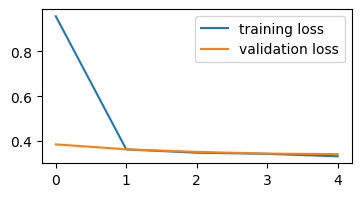

In [22]:
x_axis = np.arange(0,len(m1_train_loss))
plt.figure(figsize=(4,2))
plt.plot(x_axis, m1_train_loss, label = 'training loss')
plt.plot(x_axis, m1_val_loss, label = 'validation loss')
plt.legend()
plt.show()

In [11]:
torch.save(trainedM1,r'/content/drive/MyDrive/T5_pretrained_masked_words.pt')

In [32]:
trainedM1 = torch.load(r'/content/drive/MyDrive/T5_pretrained_masked_words.pt')
trainedM1.to('cpu');

In [41]:
EvalModel = EvalModelTraining(trainedM1, depression_symptoms_masked, masks);
M1_scores, generated_words = EvalModel.get_rougue_score();

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:240: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_

### Model M2 training and evaluation

In [43]:
# train model M1 (model on masked words data)
TrainM2 = ModelTrainer(model_tobe_trained, 5, masked_tokens_train_dataloader, masked_tokens_validation_dataloader)
trainedM2, m1_train_loss, m1_val_loss = TrainM2.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5 - Train loss: 0.5829367153119848
Validation loss: 0.40231378268111834
Epoch 2/5 - Train loss: 0.372889067939885
Validation loss: 0.3721036434173584
Epoch 3/5 - Train loss: 0.35254214750886204
Validation loss: 0.359541871601885
Epoch 4/5 - Train loss: 0.34247706141360634
Validation loss: 0.3537824820388447
Epoch 5/5 - Train loss: 0.33683844325538825
Validation loss: 0.35061033273285086


In [44]:
torch.save(trainedM2,r'/content/drive/MyDrive/T5_pretrained_masked_tokens.pt')

In [45]:
trainedM2 = torch.load(r'/content/drive/MyDrive/T5_pretrained_masked_tokens.pt')
trainedM2.to('cpu');

In [46]:
EvalModel2 = EvalModelTraining(trainedM2, depression_symptoms_masked, masks);
M2_scores, generated_tokens = EvalModel2.get_rougue_score();

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:240: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_